In [4]:
#importing necessary libraries
import shap
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns in DataFrame output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV

In [29]:
df = pd.read_csv('imdb_cleaned.csv')
df

,startYear,runtimeMinutes,totalCredits,numRegions,ratingCount,castNumber,companiesNumber,writerCredits,directorsCredits,totalNominations,totalMedia,totalReviews,Asia,Africa,Europe,North America,South America,Oceania,Continent Unknown,genre1,genre2,genre3,movie,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame,rating_bin
0,1894,1,1,5,195,0,1,0,1,0,5,0,0,0,4,1,0,0,0,16787,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1895,1,3,7,1235,0,2,0,1,0,7,5,0,0,5,1,0,0,1,16787,16581,0,0,1,0,0,0,0,0,0,0,0,1
2,1895,1,3,8,1104,0,2,0,1,0,7,6,0,0,5,1,1,0,1,47408,16787,16581,0,1,0,0,0,0,0,0,0,0,1
3,1896,1,2,4,84,0,1,0,1,0,3,0,0,0,2,1,0,0,1,47408,16787,0,0,1,0,0,0,0,0,0,0,0,1
4,1898,1,5,1,220,3,2,0,1,0,3,1,0,0,0,1,0,0,0,16787,16581,2702,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144907,1993,96,11,1,11,0,2,1,1,0,1,0,0,0,0,0,1,0,0,16581,0,0,1,0,0,0,0,0,0,0,0,0,3
144908,2019,14,52,1,15,6,3,1,1,3,10,1,0,0,1,0,0,0,0,51745,16787,0,0,1,0,0,0,0,0,0,0,0,2
144909,2019,29,32,0,12,1,0,0,0,0,5,0,0,0,0,0,0,0,0,5726,0,0,0,0,1,0,0,0,0,0,0,0,1
144910,2011,10,15,0,10,7,0,3,1,0,1,0,0,0,0,0,0,0,0,47408,17855,17763,0,0,1,0,0,0,0,0,0,0,3


# Average Rating

In [30]:
%%time

# Splitting the dataset into features (X) and target (y)
X = df.drop(columns=['rating_bin'])  # Features
y = df['rating_bin']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# One-hot encode y_train for categorical_crossentropy
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing and training the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train_scaled, y_train)

# Making predictions
y_pred = gbm.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.40195976952006346
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.24      0.32      2483
           1       0.34      0.17      0.23      3708
           2       0.36      0.37      0.37      7269
           3       0.42      0.77      0.54      9566
           4       0.44      0.06      0.10      4969
           5       0.43      0.06      0.11       988

    accuracy                           0.40     28983
   macro avg       0.41      0.28      0.28     28983
weighted avg       0.40      0.40      0.35     28983

CPU times: total: 1min 55s
Wall time: 2min 6s


In [ ]:
%%time
# Define the parameter grid for GBM
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 6, 'learning_rate': 0.1}
Best Cross-Validation Accuracy: 0.4381043569771153
CPU times: total: 16min 12s
Wall time: 4h 51min 26s


In [31]:
%%time
# Initializing and training the Gradient Boosting Classifier
gbmr = GradientBoostingClassifier(subsample= 0.8, n_estimators= 500, min_samples_split= 10, min_samples_leaf= 1, max_features= None, max_depth= 6, learning_rate= 0.1, random_state=42)
gbmr.fit(X_train_scaled, y_train)

# Making predictions
y_pred = gbmr.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.44384639271296966
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.38      0.43      2483
           1       0.37      0.26      0.31      3708
           2       0.41      0.39      0.40      7269
           3       0.47      0.67      0.56      9566
           4       0.43      0.30      0.35      4969
           5       0.44      0.22      0.29       988

    accuracy                           0.44     28983
   macro avg       0.44      0.37      0.39     28983
weighted avg       0.44      0.44      0.43     28983

CPU times: total: 17min 22s
Wall time: 19min 11s


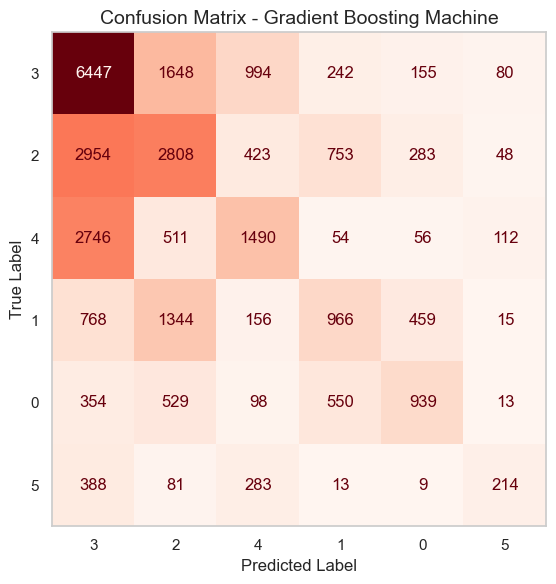

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Sort confusion matrix by support
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
support = [report[label]['support'] for label in le.classes_]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [le.classes_[i] for i in sorted_indices]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
cm_sorted = cm[sorted_indices, :][:, sorted_indices]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
disp.plot(ax=ax, cmap='Reds', colorbar=False)

# Customize appearance
ax.set_title('Confusion Matrix - Gradient Boosting Machine', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.grid(False)  # Remove gridlines
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
# --- Feature importance ---
feature_names = X.columns
importances = gbm.feature_importances_

# Convert to DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_importance_df

,Feature,Importance
4,ratingCount,0.121175
0,startYear,0.117151
1,runtimeMinutes,0.089904
24,tvEpisode,0.089682
2,totalCredits,0.080583
5,castNumber,0.061098
10,totalMedia,0.051007
19,genre1,0.050825
6,companiesNumber,0.048733
20,genre2,0.034825


C:\Users\tanya\AppData\Local\Temp\ipykernel_13868\1903393758.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


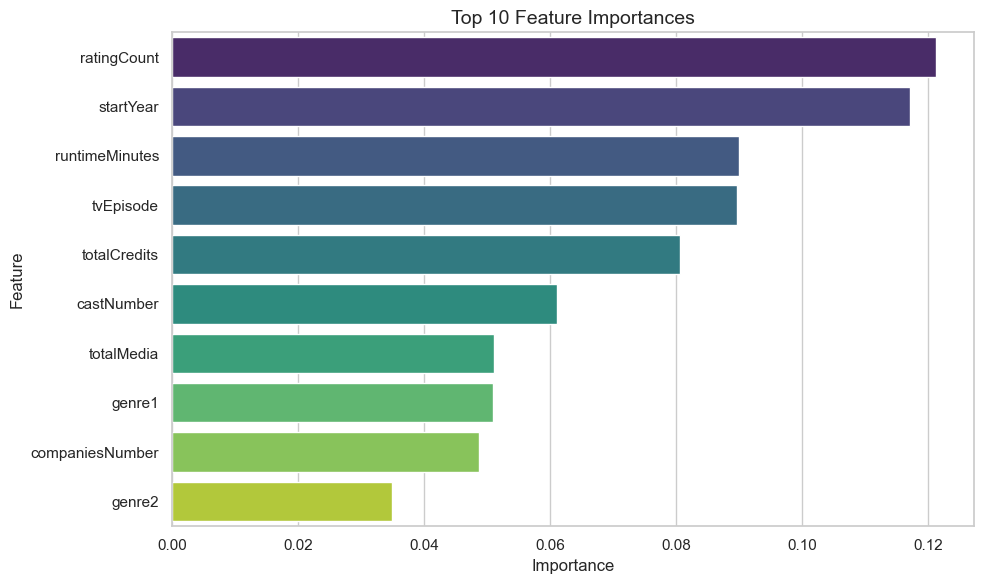

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 10 features
top_10 = feat_importance_df.head(10)

# Set Seaborn style
sns.set(style='whitegrid')

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')

# Add titles and labels
plt.title('Top 10 Feature Importances', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()


c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Gra

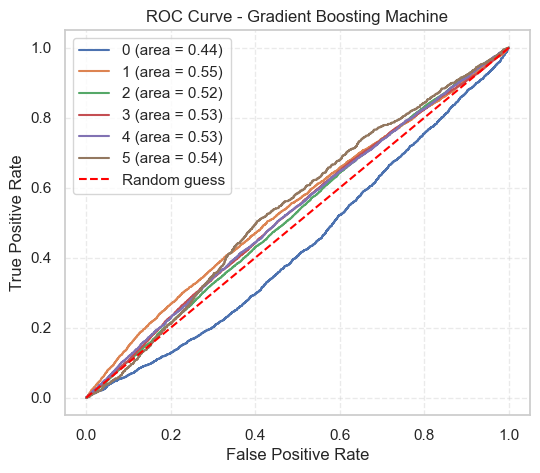

In [13]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, gbm.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(le.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Gradient Boosting Machine')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

# titleType

In [33]:
df2 = pd.read_csv('imdb_with_outliers.csv')
df3 = pd.read_csv(r"D:\BOOKS\UNIPI\Sem 2\Data Mining 2\Project\imdb.csv")
df3

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,worstRating,bestRating,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isRatable,isAdult,numRegions,userReviewsTotal,ratingCount,countryOfOrigin,genres,castNumber,companiesNumber,averageRating,regions,externalLinks,writerCredits,directorsCredits,soundMixes,quotesTotal
0,Carmencita,"(5, 6]",1894,\N,1,0,2089,1,10,2,0,4,3,short,0,False,True,0,7,16,2092,['US'],"Documentary,Short",1,3,5.7,"['\\N', 'DE', 'US', 'HU', 'GR', 'RU', 'UA', 'JP']",9,0,1,['silent'],0
1,Un bon bock,"(5, 6]",1892,\N,12,0,183,1,10,2,0,2,0,short,0,False,True,0,6,1,183,['FR'],"Animation,Short",0,0,5.4,"['\\N', 'HU', 'DE', 'FR', 'RO', 'RU', 'JP']",3,0,1,['silent'],0
2,Chinese Opium Den,"(4, 5]",1894,\N,1,0,195,1,10,1,0,1,0,short,0,False,True,0,5,0,195,['US'],Short,0,1,5.0,"['\\N', 'US', 'DE', 'PT', 'HU', 'RU']",4,0,1,['silent'],0
3,Edison Kinetoscopic Record of a Sneeze,"(5, 6]",1894,\N,1,1,2237,1,10,3,0,4,2,short,0,False,True,0,6,20,2238,['US'],"Documentary,Short",1,6,5.4,"['\\N', 'UA', 'JP', 'HU', 'US', 'DE', 'RU']",6,0,1,['silent'],0
4,L'arrivée d'un train à La Ciotat,"(7, 8]",1896,\N,1,0,13115,1,10,12,0,11,16,short,0,False,True,0,21,66,13115,['FR'],"Documentary,Short",6,5,7.4,"['\\N', 'HU', 'DE', 'TR', 'FI', 'FR', 'IT', 'E...",21,0,2,['silent'],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149526,Nuestra película,"(6, 7]",1993,\N,96,0,11,1,10,0,0,11,0,movie,0,False,True,0,1,0,11,['CO'],Documentary,0,2,7.0,"['\\N', 'CO']",1,1,1,[],0
149527,Eco,"(6, 7]",2019,\N,14,0,15,1,10,4,1,52,1,short,3,False,True,0,1,0,15,['ES'],"Drama,Short",6,3,6.4,"['\\N', 'ES']",5,1,1,[],0
149528,Women Take Center Stage,"(5, 6]",2019,\N,\N,0,12,1,10,2,3,32,0,tvEpisode,0,False,True,0,0,0,12,NaN,Reality-TV,1,0,5.6,['\\N'],0,0,0,[],0
149529,Horrid Henry and the Christening Crisis,"(7, 8]",2011,\N,10,0,9,1,10,1,0,15,0,tvEpisode,0,False,True,0,0,0,10,NaN,"Adventure,Animation,Comedy",7,0,7.1,['\\N'],0,3,1,[],0


In [34]:
#making the new dataset for new classification
df2['averageRating'] = df3['averageRating']
df2['titleType'] = df3['titleType']

# Drop observations where titleType is 'videoGame'
df2 = df2[df2['titleType'] != 'videoGame']

# Define a mapping dictionary for titleType
titletype_mapping = {
    'movie': 'movie',
    'tvMovie': 'movie',
    'short': 'short',
    'tvShort': 'short',
    'tvSeries': 'tvSeries',
    'tvMiniSeries': 'tvSeries',
    'tvEpisode': 'tvEpisode',
    'tvSpecial': 'tvSpecial',
    'video': 'video'
}

# Apply the mapping to the titleType column
df2['titleType'] = df2['titleType'].map(titletype_mapping)

# Check the new unique values
print("New unique values in titleType:", df2['titleType'].unique())


New unique values in titleType: ['short' 'movie' 'tvSeries' 'tvEpisode' 'tvSpecial' 'video']


In [35]:
#dropping rows where outlier score is -3 and -1
df2 = df2[df2['common_outlier'] != -3]
df2 = df2[df2['common_outlier'] != -1]
df2.drop(columns=['LOF_Score', 'ISF_Score', 'ABOD_Score', 'common_outlier', 't-SNE-1', 't-SNE-2','rating_bin','movie',
'tvMovie', 'short','tvShort','tvSeries','tvMiniSeries','tvEpisode','tvSpecial','video'], inplace=True)
df2

,startYear,runtimeMinutes,totalCredits,numRegions,ratingCount,castNumber,companiesNumber,writerCredits,directorsCredits,totalNominations,totalMedia,totalReviews,Asia,Africa,Europe,North America,South America,Oceania,Continent Unknown,genre1,genre2,genre3,videoGame,averageRating,titleType
2,1894,1,1,5,195,0,1,0,1,0,5,0,0,0,4,1,0,0,0,16787,0,0,0,5.0,short
6,1895,1,3,7,1235,0,2,0,1,0,7,5,0,0,5,1,0,0,1,16787,16581,0,0,5.6,short
7,1895,1,3,8,1104,0,2,0,1,0,7,6,0,0,5,1,1,0,1,47408,16787,16581,0,5.5,short
8,1896,1,2,4,84,0,1,0,1,0,3,0,0,0,2,1,0,0,1,47408,16787,0,0,5.5,short
9,1898,1,5,1,220,3,2,0,1,0,3,1,0,0,0,1,0,0,0,16787,16581,2702,0,4.2,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149526,1993,96,11,1,11,0,2,1,1,0,1,0,0,0,0,0,1,0,0,16581,0,0,0,7.0,movie
149527,2019,14,52,1,15,6,3,1,1,3,10,1,0,0,1,0,0,0,0,51745,16787,0,0,6.4,short
149528,2019,29,32,0,12,1,0,0,0,0,5,0,0,0,0,0,0,0,0,5726,0,0,0,5.6,tvEpisode
149529,2011,10,15,0,10,7,0,3,1,0,1,0,0,0,0,0,0,0,0,47408,17855,17763,0,7.1,tvEpisode


In [36]:
%%time
# Splitting the dataset into features (X) and target (y)
X = df2.drop(columns=['titleType'])   # Features
y = df2['titleType']                  # Target variable

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = gbm.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.94760907504363
Classification Report:
               precision    recall  f1-score   support

       movie       0.94      0.96      0.95      8478
       short       0.94      0.97      0.95      3060
   tvEpisode       0.97      0.98      0.97     13911
    tvSeries       0.91      0.97      0.94      1958
   tvSpecial       0.68      0.36      0.47       219
       video       0.78      0.45      0.57      1024

    accuracy                           0.95     28650
   macro avg       0.87      0.78      0.81     28650
weighted avg       0.94      0.95      0.94     28650

CPU times: total: 1min 55s
Wall time: 2min 6s


In [21]:
# Stratified sampling to ensure class distribution is maintained
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, test_idx in stratified_split.split(X, y):
    X_sampled = X.iloc[test_idx]
    y_sampled = y.iloc[test_idx]

# Display the shape of the sampled data
print("Sampled X shape:", X_sampled.shape)
print("Sampled y shape:", y_sampled.shape)

# Split the sampled data into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42
)

# Standardize the features for the sampled dataset
X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
X_test_sampled_scaled = scaler.transform(X_test_sampled)

Sampled X shape: (14325, 24)
Sampled y shape: (14325,)


In [23]:
%%time
# Define the parameter grid for GBM
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train_sampled_scaled, y_train_sampled)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
Best Cross-Validation Accuracy: 0.944153577661431
CPU times: total: 27.6 s
Wall time: 26min 32s


In [37]:
%%time
# Initializing and training the Gradient Boosting Classifier
gbmt = GradientBoostingClassifier(subsample= 0.6, n_estimators= 400, min_samples_split= 10, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 5, learning_rate= 0.05, random_state=42)
gbmt.fit(X_train_scaled, y_train)

# Making predictions
y_pred = gbmt.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Accuracy: 0.9580453752181501
Classification Report:
               precision    recall  f1-score   support

       movie       0.94      0.97      0.96      8478
       short       0.95      0.98      0.97      3060
   tvEpisode       0.98      0.98      0.98     13911
    tvSeries       0.94      0.97      0.96      1958
   tvSpecial       0.77      0.45      0.57       219
       video       0.79      0.55      0.65      1024

    accuracy                           0.96     28650
   macro avg       0.90      0.82      0.85     28650
weighted avg       0.96      0.96      0.96     28650

CPU times: total: 2min 22s
Wall time: 2min 25s


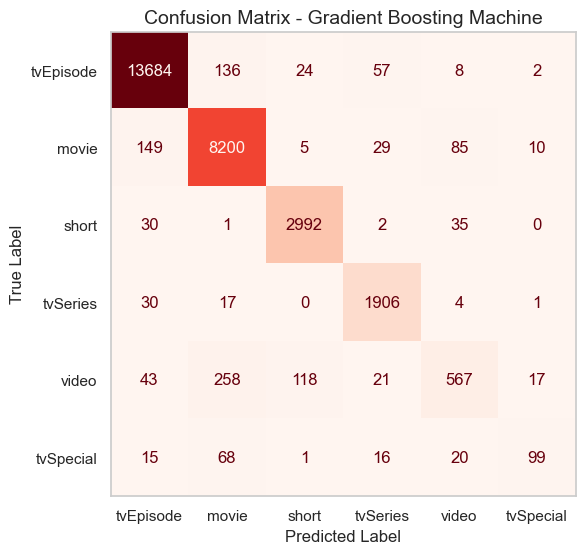

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Sort confusion matrix by support
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
support = [report[label]['support'] for label in label_encoder.classes_]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [label_encoder.classes_[i] for i in sorted_indices]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
cm_sorted = cm[sorted_indices, :][:, sorted_indices]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
disp.plot(ax=ax, cmap='Reds', colorbar=False)

# Customize appearance
ax.set_title('Confusion Matrix - Gradient Boosting Machine', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.grid(False)  # Remove gridlines
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [41]:
# --- Feature importance ---
feature_names = X.columns
importances = gbmt.feature_importances_

# Convert to DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_importance_df

,Feature,Importance
1,runtimeMinutes,0.340755
3,numRegions,0.118245
8,directorsCredits,0.073858
14,Europe,0.048665
7,writerCredits,0.046666
20,genre2,0.036866
19,genre1,0.036460
18,Continent Unknown,0.034089
0,startYear,0.032370
9,totalNominations,0.029610


C:\Users\tanya\AppData\Local\Temp\ipykernel_13868\1903393758.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


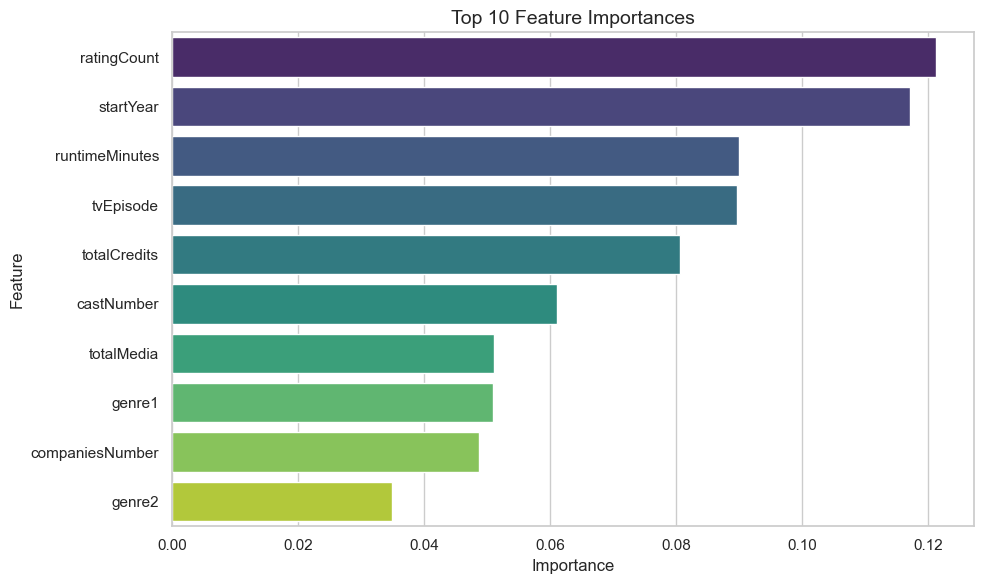

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 10 features
top_10 = feat_importance_df.head(10)

# Set Seaborn style
sns.set(style='whitegrid')

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')

# Add titles and labels
plt.title('Top 10 Feature Importances', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()


c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Gra

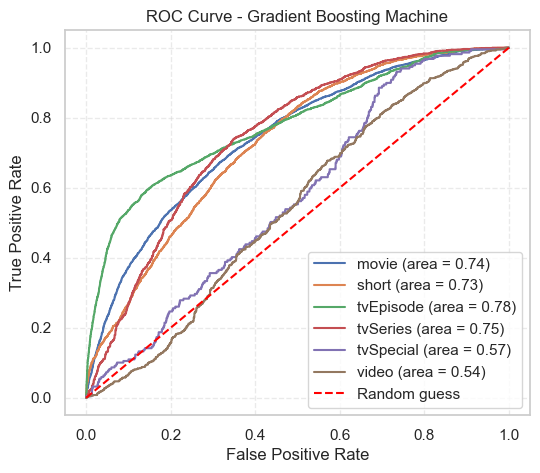

In [42]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, gbmt.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(label_encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Gradient Boosting Machine')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()